# W207 Final Project - Forest Cover Classification Kaggle Competition

Natasha Flowers, Lindsay Ng, Lucas Schroyer

Summer 2021

## Table of Contents

* [Competition Description and Imports](#data_description)
* [Exploratory Data Analysis](#eda)
* [Modeling](#modeling)
    * [K-Nearest Neighbors](#knn)
    * [Naive Bayes](#nb)
    * [Logistic Regression](#lr)
    * [Decision Trees](#dt)
    * [Random Forests](#rf)
    * [Support Vector Machines](#svm)
    * [AdaBoost](#ab)
* [Feature Engineering](#feat)    
* [Ensemble Models](#ensemble)
* [Test Data](#test)
* [Kaggle Submission](#conc)

## Competition Description  <a class="anchor" id="data_description"></a>

In this competition we are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains continuous variables for characteristics like elevation and distance to features of interest as well as binary indicators for qualitative variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

The following features describe each patch of forest and are used to classify cover type:

- Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

### Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import warnings

# Import SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

#Import SK-learn libraries for preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Import SK-learn libraries for evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Display settings
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [65]:
# Read in training dataset provided by Kaggle
train_df = pd.read_csv('./data/train.csv')
print("Shape is:", train_df.shape)
print("Columns are:", train_df.columns)

Shape is: (15120, 56)
Columns are: Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', '

## Exploratory Data Analysis  <a class="anchor" id="eda"></a>

### Quality Checks

We performed a series of quality checks to ensure our dataset was complete and logical. First, we looked at some baseline metrics for all of the features, including count, mean, standard deviation, and quartile values. We found no missing or unreasonable values.

In [4]:
# Describe the columns
train_df_summary = train_df.describe().transpose()
train_df_summary

count         mean          std     min  \
Id                                  15120.0  7560.500000  4364.912370     1.0   
Elevation                           15120.0  2749.322553   417.678187  1863.0   
Aspect                              15120.0   156.676653   110.085801     0.0   
Slope                               15120.0    16.501587     8.453927     0.0   
Horizontal_Distance_To_Hydrology    15120.0   227.195701   210.075296     0.0   
Vertical_Distance_To_Hydrology      15120.0    51.076521    61.239406  -146.0   
Horizontal_Distance_To_Roadways     15120.0  1714.023214  1325.066358     0.0   
Hillshade_9am                       15120.0   212.704299    30.561287     0.0   
Hillshade_Noon                      15120.0   218.965608    22.801966    99.0   
Hillshade_3pm                       15120.0   135.091997    45.895189     0.0   
Horizontal_Distance_To_Fire_Points  15120.0  1511.147288  1099.936493     0.0   
Wilderness_Area1                    15120.0     0.237897     0.425810     0.0   
Wilderness_Area2                    15120.0     0.033003     0.178649     0.0   
Wilderness_Area3                    15120.0     0.419907     0.493560     0.0   
Wilderness_Area4                    15120.0     0.309193     0.462176     0.0   
Soil_Type1                          15120.0     0.023479     0.151424     0.0   
Soil_Type2                          15120.0     0.041204     0.198768     0.0   
Soil_Type3                          15120.0     0.063624     0.244091     0.0   
Soil_Type4                          15120.0     0.055754     0.229454     0.0   
Soil_Type5                          15120.0     0.010913     0.103896     0.0   
Soil_Type6                          15120.0     0.042989     0.202840     0.0   
Soil_Type7                          15120.0     0.000000     0.000000     0.0   
Soil_Type8                          15120.0     0.000066     0.008133     0.0   
Soil_Type9                          15120.0     0.000661     0.025710     0.0   
Soil_Type10                         15120.0     0.141667     0.348719     0.0   
Soil_Type11                         15120.0     0.026852     0.161656     0.0   
Soil_Type12                         15120.0     0.015013     0.121609     0.0   
Soil_Type13                         15120.0     0.031481     0.174621     0.0   
Soil_Type14                         15120.0     0.011177     0.105133     0.0   
Soil_Type15                         15120.0     0.000000     0.000000     0.0   
Soil_Type16                         15120.0     0.007540     0.086506     0.0   
Soil_Type17                         15120.0     0.040476     0.197080     0.0   
Soil_Type18                         15120.0     0.003968     0.062871     0.0   
Soil_Type19                         15120.0     0.003042     0.055075     0.0   
Soil_Type20                         15120.0     0.009193     0.095442     0.0   
Soil_Type21                         15120.0     0.001058     0.032514     0.0   
Soil_Type22                         15120.0     0.022817     0.149326     0.0   
Soil_Type23                         15120.0     0.050066     0.218089     0.0   
Soil_Type24                         15120.0     0.016997     0.129265     0.0   
Soil_Type25                         15120.0     0.000066     0.008133     0.0   
Soil_Type26                         15120.0     0.003571     0.059657     0.0   
Soil_Type27                         15120.0     0.000992     0.031482     0.0   
Soil_Type28                         15120.0     0.000595     0.024391     0.0   
Soil_Type29                         15120.0     0.085384     0.279461     0.0   
Soil_Type30                         15120.0     0.047950     0.213667     0.0   
Soil_Type31                         15120.0     0.021958     0.146550     0.0   
Soil_Type32                         15120.0     0.045635     0.208699     0.0   
Soil_Type33                         15120.0     0.040741     0.197696     0.0   
Soil_Type34                         15120.0     0.001455     0.038118

We also checked the dataset to make sure there were no missing values or duplicated IDs. We found the dataset to be complete and free from duplicate entries.

In [5]:
train_df.isnull().sum(axis = 0)

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


In [6]:
# Check number of duplicated IDs
sum(train_df.pivot_table(index=['Id'], aggfunc='size') > 1)

0

### Examine specific variables

Next, we examined specific variables including wilderness area, soil type, and hillshade to make sure we understood how the variable was constructed and what it was representing. We determined that each observation has a single Wilderness Area and Soil Type. The distributions of Wilderness Areas and Soil Types within the dataset are not uniform; some values are much more common than others.

In [6]:
# Describe binary wilderness area columns
print(train_df.filter(regex=r'Wilderness_Area*').mean().sort_values(ascending=False))
print("Check total:", sum(train_df.filter(regex=r'Wilderness_Area*').mean()))

Wilderness_Area3    0.419907
Wilderness_Area4    0.309193
Wilderness_Area1    0.237897
Wilderness_Area2    0.033003
dtype: float64
Check total: 1.0


In [7]:
print(train_df.filter(regex=r'Wilderness_Area*').describe())

       Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  Wilderness_Area4
count      15120.000000      15120.000000      15120.000000      15120.000000
mean           0.237897          0.033003          0.419907          0.309193
std            0.425810          0.178649          0.493560          0.462176
min            0.000000          0.000000          0.000000          0.000000
25%            0.000000          0.000000          0.000000          0.000000
50%            0.000000          0.000000          0.000000          0.000000
75%            0.000000          0.000000          1.000000          1.000000
max            1.000000          1.000000          1.000000          1.000000


In [8]:
# Describe (binary) soil type columns
train_df.filter(regex=r'Soil_Type*').mean().sort_values(ascending=False)

Soil_Type10    0.141667
Soil_Type29    0.085384
Soil_Type3     0.063624
Soil_Type4     0.055754
Soil_Type23    0.050066
Soil_Type38    0.048148
Soil_Type30    0.047950
Soil_Type32    0.045635
Soil_Type39    0.043452
Soil_Type6     0.042989
Soil_Type2     0.041204
Soil_Type33    0.040741
Soil_Type17    0.040476
Soil_Type13    0.031481
Soil_Type40    0.030357
Soil_Type11    0.026852
Soil_Type1     0.023479
Soil_Type22    0.022817
Soil_Type31    0.021958
Soil_Type24    0.016997
Soil_Type12    0.015013
Soil_Type14    0.011177
Soil_Type5     0.010913
Soil_Type20    0.009193
Soil_Type16    0.007540
Soil_Type35    0.006746
Soil_Type18    0.003968
Soil_Type26    0.003571
Soil_Type19    0.003042
Soil_Type37    0.002249
Soil_Type34    0.001455
Soil_Type21    0.001058
Soil_Type27    0.000992
Soil_Type9     0.000661
Soil_Type36    0.000661
Soil_Type28    0.000595
Soil_Type25    0.000066
Soil_Type8     0.000066
Soil_Type7     0.000000
Soil_Type15    0.000000
dtype: float64

Trees plots in the shadow of other tree plots at 9AM: 1

Tree plots in the shadow of other tree plots at 12PM: 0

Trees plots in the shadow of other tree plots at 3PM: 88


array([[<AxesSubplot:title={'center':'Hillshade_9am'}>],
       [<AxesSubplot:title={'center':'Hillshade_Noon'}>],
       [<AxesSubplot:title={'center':'Hillshade_3pm'}>]], dtype=object)

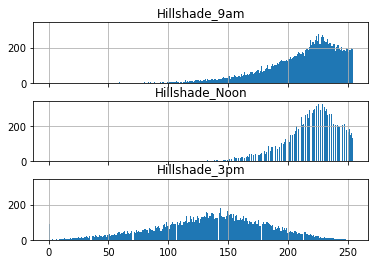

In [9]:
# Hillshade variables
# Additional info found at https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/hillshade.htm
# The hillshade raster has an integer value range of 0 to 255. A value of 0 is shaded where a value of 255 is not.
print("Trees plots in the shadow of other tree plots at 9AM:", sum(train_df.Hillshade_9am ==0))
print("\nTree plots in the shadow of other tree plots at 12PM:", sum(train_df.Hillshade_Noon ==0))
print("\nTrees plots in the shadow of other tree plots at 3PM:", sum(train_df.Hillshade_3pm ==0))

train_df.filter(regex=r'^(Hillshade)').hist(sharex=True, sharey=True, bins = int(255/1), layout = (3,1))

Additionally, we plotted each of the feature distributions against each other to look for linear correlations or interesing patterns from feature interactions. 

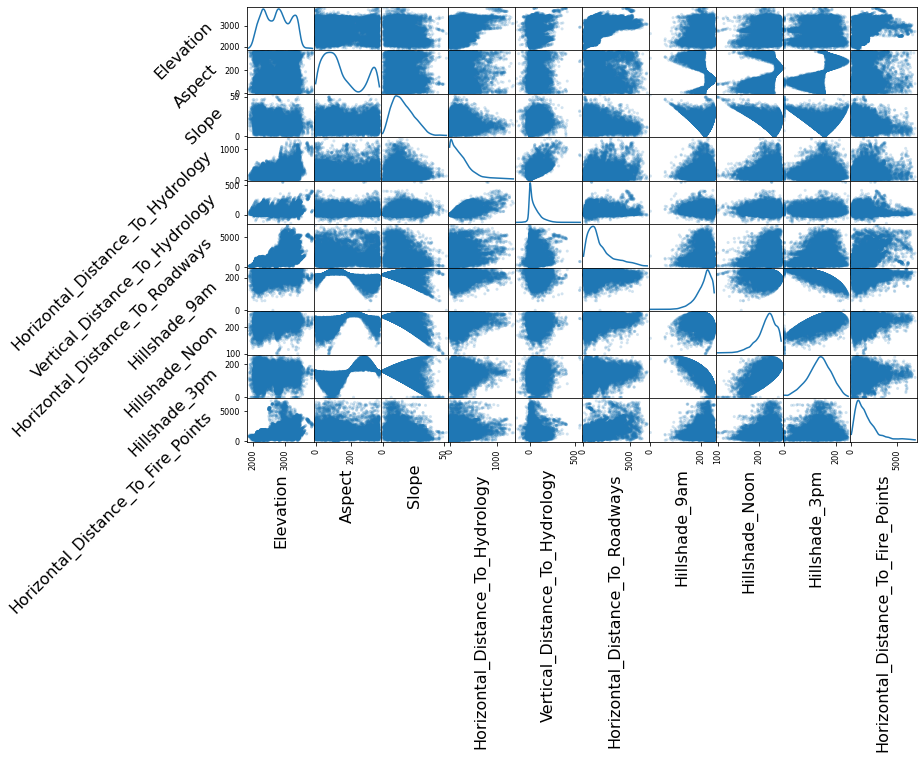

In [10]:
# Scatter plot of all variables
axes = pd.plotting.scatter_matrix(
    train_df.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Id)').filter(
        regex=r'^(?!Wilderness_Area)'),
    alpha=0.2, 
    figsize=(12, 8), diagonal='kde')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_fontsize(16)
    ax.yaxis.label.set_ha('right')

plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

### Outcome Exploration

Next, we looked in more depth at the outcome variable, cover_type. We checked the cover type distribution and looked for sets of features that could reliably separate the cover types. We found that each cover type is represented equally in the given training data, which is helpful in terms of avoiding bias but makes us suspect that the composition of this training dataset may not reflect the composition of the forest area more generally. We also found that elevation alone could separate the cover types pretty well, so we expect this feature will be important in our models. 

In [11]:
# Check frequency of cover types in data
train_df['Cover_Type'].value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

<AxesSubplot:xlabel='Elevation', ylabel='Horizontal_Distance_To_Hydrology'>

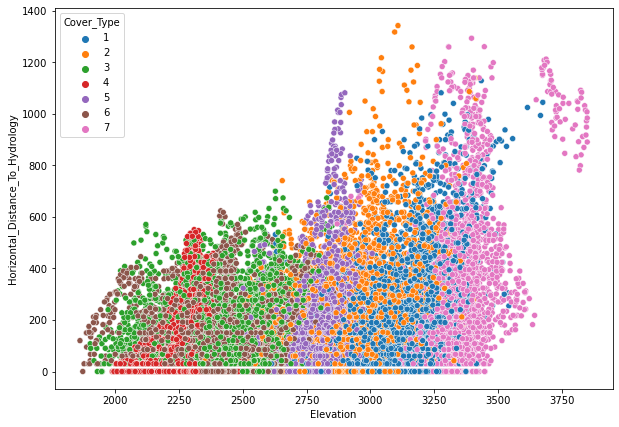

In [12]:
# Plot elevation, horizontal distance to hydrology, cover type
train_df['Cover_Type'] = train_df['Cover_Type'].astype('category')
plt.figure(figsize=(10,7))
sns.scatterplot(data=train_df, x="Elevation", y="Horizontal_Distance_To_Hydrology", hue="Cover_Type")

<AxesSubplot:xlabel='Elevation', ylabel='Horizontal_Distance_To_Roadways'>

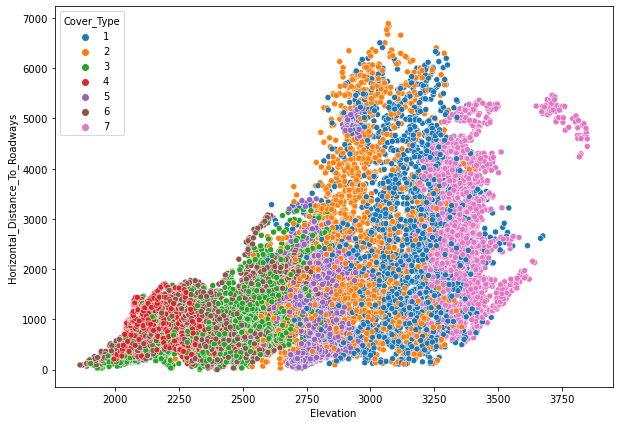

In [13]:
# Plot elevation, horizontal distance to roadways, cover type
train_df['Cover_Type'] = train_df['Cover_Type'].astype('category')
plt.figure(figsize=(10,7))
sns.scatterplot(data=train_df, x="Elevation", y="Horizontal_Distance_To_Roadways", hue="Cover_Type")

## Modeling  <a class="anchor" id="modeling"></a>

### Modeling setup

To predict the 7 forest cover types, we implemented many of the machine learning models learned in class, in addition to a few that we investigated outside of class. The following work shows our progression for improving the various models we tried. For each model, we present the base model, improvements from scaling and/or PCA, and the confusion matrix for the highest performing version of each type of model. We start this section with setup - including shuffling the data and partitioning it into a training set, dev set, and test set:

In [66]:
# Shuffle the available data
np.random.seed(0)
shuffle = np.random.permutation(np.arange(train_df.shape[0]))
train_df = train_df.iloc[shuffle]

# Assign desired number of obs to each partition
num_train = int(train_df.shape[0] * 0.6)
num_dev = int(train_df.shape[0] * 0.2)
# test data will be remaining after train and dev are separated

# Remove ID variable (first) and cover type variable (last), and split the observations into the different partitions
train_data, train_labels = train_df.iloc[:num_train,1:-1], train_df.iloc[:num_train,-1:]
dev_data, dev_labels = train_df.iloc[num_train:num_train + num_dev,1:-1], train_df.iloc[num_train:num_train + num_dev,-1:]
test_data, test_labels  = train_df.iloc[num_train + num_dev:,1:-1], train_df.iloc[num_train + num_dev:,-1:]

print("Available data: ", train_df.shape)
print("Training partition: ", train_data.shape)
print("Dev partition: ", dev_data.shape)
print("Test partition: ", test_data.shape)

# Scale the data for later use
train_data_normalized = scale(train_data)
dev_data_normalized = scale(dev_data)
test_data_normalized = scale(test_data)

# Provide cover type list and labels for output labeling
cover_types = [1,2,3,4,5,6,7]
cover_labels = ["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine", "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"]

Available data:  (15120, 56)
Training partition:  (9072, 54)
Dev partition:  (3024, 54)
Test partition:  (3024, 54)


#### Elevation Logistic Regression Model

We began this process with the simplest model possible, a logistic regression on a single feature. We chose elevation as our single feature as it separates the cover types nicely, based on the EDA presented above. Using this as our true baseline, we were able to compare each of our more sophisticated models to get a sense of how they were performing relative to this quick and simple approach.

In [9]:
# Train a logistic regression model on the elevation variable
train_data_elevation = train_data.filter(
        regex=r'^(Elevation)')
dev_data_elevation = dev_data.filter(
        regex=r'^(Elevation)')

LR = LogisticRegression()
LR.fit(train_data_elevation, train_labels.values.ravel())
dev_data_pred_LR_elevation = LR.predict(dev_data_elevation)
f1_score_LR = metrics.f1_score(dev_labels, dev_data_pred_LR_elevation, average="weighted")

print("\nElevation LR Model - F1-Score:", round(f1_score_LR,2))


Elevation LR Model - F1-Score: 0.54


### K-Nearest Neighbors  <a class="anchor" id="knn"></a>

K-Nearest Neighbors is an algorithm that uses the k closest training examples in the training set to predict the class of a new observation.

#### Base Model

In [11]:
# Train the base kneighbor model with default parameters
train_data_neigh = train_data
dev_data_neigh = dev_data

neigh = KNeighborsClassifier()
neigh.fit(train_data_neigh, train_labels.values.ravel())
dev_data_pred = neigh.predict(dev_data_neigh)
f1_score_kneigh = metrics.f1_score(dev_labels, dev_data_pred, average="weighted")

print("\nBase K Nearest Neighbor Model - F1-Score:", round(f1_score_kneigh,2))


Base K Nearest Neighbor Model - F1-Score: 0.78


#### Scale the Data

In [12]:
# Scale the data and retrain the neighbors
train_data_normalized = scale(train_data_neigh)
dev_data_normalized = scale(dev_data_neigh)

neigh = KNeighborsClassifier()
neigh.fit(train_data_normalized, train_labels.values.ravel())
dev_data_pred = neigh.predict(dev_data_normalized)
f1_score_kneigh = metrics.f1_score(dev_labels, dev_data_pred, average="weighted")

print("\nScaled Base Model - F1-Score:", round(f1_score_kneigh,2))


Scaled Base Model - F1-Score: 0.75


Here we see that scaling the data actually decreased the F1 score. We think this may be because some of the more important features in our data (such as elevation) have fairly high numbers associated with them in the raw data compared to potentially less important features (such as binary soil type), so it happens that those features being overemphasized in the raw data is actually beneficial for the model. For now, we will proceed to try optimizing the model using unscaled data.

#### Optimize the hyperparameters

In [102]:
train_data_optim_param = train_data_neigh
dev_data_optim_param = dev_data_neigh

warnings.filterwarnings('ignore')

neigh = KNeighborsClassifier(weights = 'distance')

#set values of hyperparameters
step = 1
params = {'n_neighbors': range(1,10,step),
         'p': range(1,10,1)}

#initiate gridsearch and fit model
clf = GridSearchCV(neigh, params, cv=None, scoring='accuracy')
clf.fit(train_data_optim_param, train_labels)

#show results of gridsearch
print("The best value of K is", clf.best_params_["n_neighbors"])
print("The best value of p is", clf.best_params_["p"])

#print the results of the grid search
warnings.filterwarnings(action = "default")
print(pd.DataFrame(clf.cv_results_).loc[:, ["params", "mean_test_score"]].sort_values(
    "mean_test_score", axis=0, ascending=False).head(),
      "\n...\n",
     pd.DataFrame(clf.cv_results_).loc[:, ["params", "mean_test_score"]].sort_values(
    "mean_test_score", axis=0, ascending=False).tail())

#retrain neighbors with the optimal paramters and calculate the best F1 score
neigh = KNeighborsClassifier(n_neighbors = clf.best_params_["n_neighbors"], 
                             p = clf.best_params_["p"])
neigh.fit(train_data_optim_param, train_labels.values.ravel())
dev_data_pred = neigh.predict(dev_data_optim_param)
f1_score_kneigh = metrics.f1_score(dev_labels, dev_data_pred, average="weighted")

print("\nOptimized Parameter Model - F1-Score:", round(f1_score_kneigh,2))

The best value of K is 2
The best value of p is 1
                        params  mean_test_score
9   {'n_neighbors': 2, 'p': 1}         0.811838
0   {'n_neighbors': 1, 'p': 1}         0.811838
18  {'n_neighbors': 3, 'p': 1}         0.807430
27  {'n_neighbors': 4, 'p': 1}         0.806437
1   {'n_neighbors': 1, 'p': 2}         0.805886 
...
                         params  mean_test_score
69  {'n_neighbors': 8, 'p': 7}         0.758158
79  {'n_neighbors': 9, 'p': 8}         0.756505
77  {'n_neighbors': 9, 'p': 6}         0.756395
78  {'n_neighbors': 9, 'p': 7}         0.755954
80  {'n_neighbors': 9, 'p': 9}         0.755844

Optimized Parameter Model - F1-Score: 0.79


#### PCA

In [107]:
# Split the training and dev data into continous and categorical/discrete data frames
train_data_continuous = train_data.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Wilderness_Area)')

train_data_discrete = train_data.filter(
        regex=r'^(Soil_Type)').filter(
        regex=r'^(Cover_Type)').filter(
        regex=r'^(Wilderness_Area)')

dev_data_continuous = dev_data.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Wilderness_Area)')

dev_data_discrete = dev_data.filter(
        regex=r'^(Soil_Type)').filter(
        regex=r'^(Cover_Type)').filter(
        regex=r'^(Wilderness_Area)')

# Run a PCA analysis for various number of PCA features/vectors n and train on the continous data.
# Then rejoin the discrete data to run the k-neighbor models
for n in range(1,11):
    #calculate PCA vectors for n with the continous data
    pca = PCA(n_components=n).fit(train_data_continuous)
    
    #rejoin the discrete data
    principal_components_train = np.column_stack((pca.transform(train_data_continuous),train_data_discrete))
    principal_components_dev = np.column_stack((pca.transform(dev_data_continuous), dev_data_discrete))

    #initialize empty list for storing model results when looping over different parameters
    f1_score_kneigh = []
    param_list = []
    step = 1
    
    #search for optimal point around the base model grid search max combination
    k_range_i = range(1,10,step)
    p_range_j = range(1,5,step)

    #loop over different values of k and p near the optimal point from the non-pca analysis 
    for k_i in k_range_i:
        for p_j in p_range_j:
            neigh = KNeighborsClassifier(n_neighbors = k_i, weights = 'distance', p = p_j)
            neigh.fit(principal_components_train, train_labels.values.ravel())

            dev_data_pred = neigh.predict(principal_components_dev)

            
            f1_score_kneigh.append(metrics.f1_score(dev_labels, dev_data_pred, average="weighted"))
            param_list.append((k_i, p_j))

    #Print the model results
    overall_f1_score = round(max(f1_score_kneigh),2)
    overall_f1_score_loc = f1_score_kneigh.index(max(f1_score_kneigh))
    
    print("\nOverall Maximum F1-Score at pca_n =", n,":", overall_f1_score,
          "at K =",param_list[overall_f1_score_loc][0],
          "and P =",param_list[overall_f1_score_loc][1])


Overall Maximum F1-Score at pca_n = 1 : 0.26 at K = 8 and P = 1

Overall Maximum F1-Score at pca_n = 2 : 0.43 at K = 7 and P = 1

Overall Maximum F1-Score at pca_n = 3 : 0.71 at K = 5 and P = 1

Overall Maximum F1-Score at pca_n = 4 : 0.79 at K = 1 and P = 2

Overall Maximum F1-Score at pca_n = 5 : 0.81 at K = 4 and P = 1

Overall Maximum F1-Score at pca_n = 6 : 0.81 at K = 1 and P = 1

Overall Maximum F1-Score at pca_n = 7 : 0.81 at K = 1 and P = 2

Overall Maximum F1-Score at pca_n = 8 : 0.82 at K = 1 and P = 1

Overall Maximum F1-Score at pca_n = 9 : 0.82 at K = 1 and P = 1

Overall Maximum F1-Score at pca_n = 10 : 0.82 at K = 1 and P = 1


#### Confusion Matrix


/Users/ls_enel/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.72
2	Lodgepole Pine  	 0.58
3	Ponderosa Pine  	 0.78
4	Cottonwood/Willow	 0.90
5	Aspen           	 0.89
6	Douglas-fir     	 0.77
7	Krummholz       	 0.92


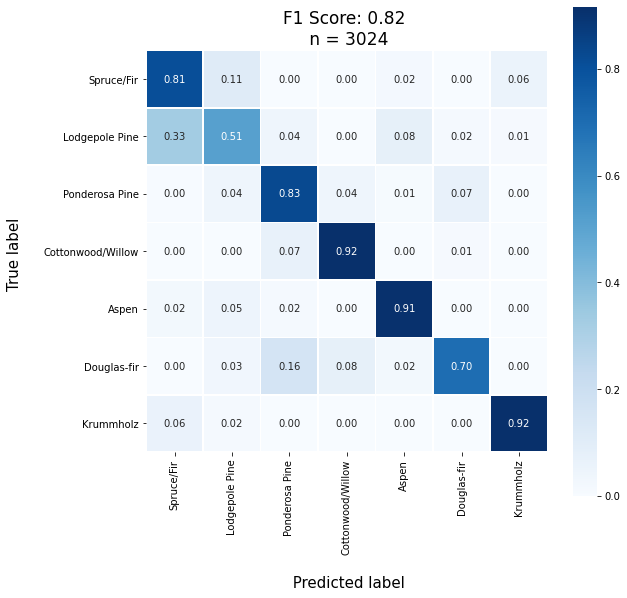

In [112]:
#From the PCA analysis, recreate the best model
pca = PCA(n_components=10).fit(train_data_continuous)
principal_components_train = np.column_stack((pca.transform(train_data_continuous),train_data_discrete))
principal_components_dev = np.column_stack((pca.transform(dev_data_continuous), dev_data_discrete))
neigh_best = KNeighborsClassifier(n_neighbors=2, p=1)
neigh_best.fit(principal_components_train, train_labels.values.ravel())
dev_data_pred = neigh_best.predict(principal_components_dev)

#Calculate the class F1 scores and print the results
class_f1_scores =  metrics.f1_score(dev_labels, dev_data_pred, average=None)

print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')

#Confusion Matrix
cm = metrics.confusion_matrix(dev_labels, dev_data_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels, )
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(overall_f1_score, dev_data_pred.size)
plt.title(all_sample_title, size = 17);

The base K Nearest neighbors model resulted in an F1 score of 0.78. Through optimizing the hyperparamters and decreasing the noise in the continous variables, we were able to increase the model performance to get an F1 score of 0.82.

### Naive Bayes  <a class="anchor" id="nb"></a>

Naive Bayes is a probabilistic classifier based on applying Bayes' theorem with strong (naïve) independence assumptions between the features.

In [13]:
#Base Model
train_data_NB = train_data
dev_data_NB = dev_data

#Have to scale data since baseline data contains negative values, which cannot be passed to MultinomialNB
scaler = preprocessing.MinMaxScaler()
# fit scaler on data
scaler.fit(train_data_NB)
# apply transform
train_data_normalized_NB = pd.DataFrame(scaler.transform(train_data_NB), columns = train_data_NB.columns)
dev_data_normalized_NB  = pd.DataFrame(scaler.transform(dev_data_NB), columns = dev_data_NB.columns)

NB = MultinomialNB()
NB.fit(train_data_normalized_NB, train_labels.values.ravel())
dev_data_pred_NB = NB.predict(dev_data_normalized_NB)
f1_score_NB = metrics.f1_score(dev_labels, dev_data_pred_NB, average="weighted")

print("\nBase NB Model - F1-Score:", round(f1_score_NB,2))


Base NB Model - F1-Score: 0.59


#### Optimize the hyperparameters

In [14]:
warnings.filterwarnings('ignore')

train_data_optim_param = train_data_normalized_NB
dev_data_optim_param = dev_data_normalized_NB

#create a base Multinomial Naive Bayes model
NB = MultinomialNB()

#set values of hyperparameters
step = 0.05
params = {'alpha': np.arange(0.0, 5, step), 
          'fit_prior': [True, False]}

#initiate gridsearch and fit model
clf = GridSearchCV(NB, params, cv=None, scoring='accuracy')
clf.fit(train_data_optim_param, train_labels)

#show results of gridsearch
print("The best value of alpha is", clf.best_params_["alpha"])
print("The best value of fit_prior is", clf.best_params_["fit_prior"])

warnings.filterwarnings(action = "default")
print(pd.DataFrame(clf.cv_results_).loc[:, ["params", "mean_test_score"]].sort_values(
    "mean_test_score", axis=0, ascending=False).head(), "\n...\n", 
     pd.DataFrame(clf.cv_results_).loc[:, ["params", "mean_test_score"]].sort_values(
    "mean_test_score", axis=0, ascending=False).tail())


NB = MultinomialNB(alpha = clf.best_params_["alpha"], fit_prior = clf.best_params_["fit_prior"])
NB.fit(train_data_optim_param, train_labels.values.ravel())
dev_data_pred_NB = NB.predict(dev_data_optim_param)
f1_score_NB = metrics.f1_score(dev_labels, dev_data_pred_NB, average="weighted")

print("\nOptimized Parameter Model - F1-Score:", round(f1_score_NB,2))

The best value of alpha is 3.5
The best value of fit_prior is True
                                               params  mean_test_score
146  {'alpha': 3.6500000000000004, 'fit_prior': True}         0.584324
164  {'alpha': 4.1000000000000005, 'fit_prior': True}         0.584324
168                 {'alpha': 4.2, 'fit_prior': True}         0.584324
170                {'alpha': 4.25, 'fit_prior': True}         0.584324
172                 {'alpha': 4.3, 'fit_prior': True}         0.584324 
...
                                                 params  mean_test_score
21                  {'alpha': 0.5, 'fit_prior': False}          0.58256
19                 {'alpha': 0.45, 'fit_prior': False}          0.58256
13  {'alpha': 0.30000000000000004, 'fit_prior': False}          0.58256
15  {'alpha': 0.35000000000000003, 'fit_prior': False}          0.58256
17                  {'alpha': 0.4, 'fit_prior': False}          0.58256

Optimized Parameter Model - F1-Score: 0.59


Searching for optimal parameters via gridsearch did not lead to any improvements in model performance.

#### PCA

In [16]:
warnings.filterwarnings('ignore')

#Split the data into continous/discrete for PCA analysis
train_data_NB_PCA = train_data_normalized_NB
dev_data_NB_PCA = dev_data_normalized_NB

train_data_continuous = train_data_NB_PCA.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Wilderness_Area)')

train_data_discrete = train_data_NB_PCA.filter(
        regex=r'^(Soil_Type)').filter(
        regex=r'^(Cover_Type)').filter(
        regex=r'^(Wilderness_Area)')

dev_data_continuous = dev_data_NB_PCA.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Wilderness_Area)')

dev_data_discrete = dev_data_NB_PCA.filter(
        regex=r'^(Soil_Type)').filter(
        regex=r'^(Cover_Type)').filter(
        regex=r'^(Wilderness_Area)')

#Loop over different n values for the PCA and find the optimal paramters for Naive Bayes
for n in range(1,11):
    #create the PCA for different values of n
    pca = PCA(n_components=n).fit(train_data_continuous)
    principal_components_train = pca.transform(train_data_continuous)
    principal_components_dev = pca.transform(dev_data_continuous)
    principal_components_train = pd.DataFrame(principal_components_train).clip(lower=0)
    principal_components_dev = pd.DataFrame(principal_components_dev).clip(lower=0)
    
    #create an empty list to append loop results too
    f1_score_NB = []
    param_list = []
    #search for optimal point around the base model grid search max combination
    step = 0.05
    alpha_range = np.arange(0.0, 5, step)
    
    #loop over alpha values
    for alpha_i in alpha_range:
        NB = MultinomialNB(alpha = alpha_i, fit_prior = True)
        NB.fit(principal_components_train, train_labels.values.ravel())

        dev_data_pred = NB.predict(principal_components_dev)

        f1_score_NB.append(metrics.f1_score(dev_labels, dev_data_pred, average="weighted"))
        param_list.append(alpha_i)

    overall_f1_score = round(max(f1_score_NB),2)
    overall_f1_score_loc = f1_score_NB.index(max(f1_score_NB))
    
    print("\nOverall Maximum F1-Score at pca_n =", n, ": F1 score =", overall_f1_score,
          "at Alpha =",round(param_list[overall_f1_score_loc], 3))


Overall Maximum F1-Score at pca_n = 1 : F1 score = 0.03 at Alpha = 0.0

Overall Maximum F1-Score at pca_n = 2 : F1 score = 0.11 at Alpha = 0.0

Overall Maximum F1-Score at pca_n = 3 : F1 score = 0.18 at Alpha = 1.8

Overall Maximum F1-Score at pca_n = 4 : F1 score = 0.24 at Alpha = 2.1

Overall Maximum F1-Score at pca_n = 5 : F1 score = 0.3 at Alpha = 0.05

Overall Maximum F1-Score at pca_n = 6 : F1 score = 0.33 at Alpha = 0.0

Overall Maximum F1-Score at pca_n = 7 : F1 score = 0.41 at Alpha = 0.8

Overall Maximum F1-Score at pca_n = 8 : F1 score = 0.41 at Alpha = 0.15

Overall Maximum F1-Score at pca_n = 9 : F1 score = 0.41 at Alpha = 0.0

Overall Maximum F1-Score at pca_n = 10 : F1 score = 0.41 at Alpha = 0.3


Here we see that PCA actually decreases the F1 score, so we choose not to use it for the best NB model.

#### Confusion Matrix


Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.46
2	Lodgepole Pine  	 0.48
3	Ponderosa Pine  	 0.45
4	Cottonwood/Willow	 0.72
5	Aspen           	 0.60
6	Douglas-fir     	 0.55
7	Krummholz       	 0.85


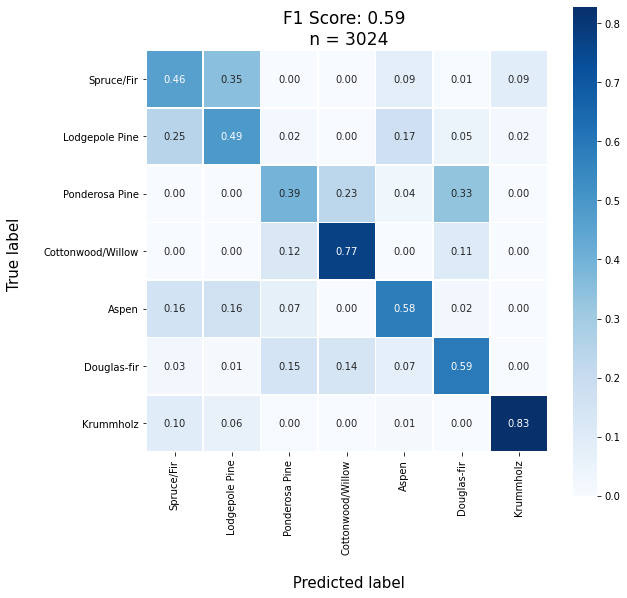

In [17]:
NB = MultinomialNB(alpha = clf.best_params_["alpha"], fit_prior = clf.best_params_["fit_prior"])
NB.fit(train_data_optim_param, train_labels.values.ravel())
dev_data_pred_NB = NB.predict(dev_data_optim_param)

f1_score_NB = metrics.f1_score(dev_labels, dev_data_pred_NB, average="weighted")

class_f1_scores =  metrics.f1_score(dev_labels, dev_data_pred_NB, average=None)

print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')

#Confusion Matrix
cm = metrics.confusion_matrix(dev_labels, dev_data_pred_NB)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels, )
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(f1_score_NB, dev_data_pred_NB.size)
plt.title(all_sample_title, size = 17);

Naive Bayes does not perform well for this analysis compared to other models we tried, likely due to its base assumption of independence between features. While the linearity plot from the EDA section shows no strong linear dependence between continuous features, the fact that so many of the features are binary (e.g. the 40 soil type features) may result in some linear dependencies in the data. Interestingly, none of the efforts to scale the data or reduce the dimensionality with PCA helped to resolve this issue.

### Logistic Regression 

The Logistic Regression model is used to model the probability of a certain class or event existing or not existing. This can be extended to model multiple classes as well. Each data point being classified is assigned a probability between 0 and 1 for each class, with a sum the sum of the probabilities across all the classes equaling 100%.

In [18]:
#Base Logistic Regression Model with default parameters
train_data_LR = train_data 
dev_data_LR = dev_data

LR = LogisticRegression()
LR.fit(train_data_LR, train_labels.values.ravel())
dev_data_pred_LR = LR.predict(dev_data_LR)
f1_score_LR = metrics.f1_score(dev_labels, dev_data_pred_LR, average="weighted")

print("\nBase Logistic Regression Model - F1-Score:", round(f1_score_LR,2))


Base Logistic Regression Model - F1-Score: 0.48


#### Scale the Data

In [21]:
#Scale the data and retrain the logistic regression model
train_data_normalized_LR = scale(train_data_LR)
dev_data_normalized_LR = scale(dev_data_LR)

LR = LogisticRegression()
LR.fit(train_data_normalized_LR, train_labels.values.ravel())
dev_data_pred_LR = LR.predict(dev_data_normalized_LR)
f1_score_LR = metrics.f1_score(dev_labels, dev_data_pred_LR, average="weighted")

print("\nScaled Base Model - F1-Score:", round(f1_score_LR,3))


Scaled Base Model - F1-Score: 0.698


#### Optimize Parameters & Stack Logistic Regression Models

Regularization Stengths:
0.0, only L1 converged for c = 0.0001
0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 

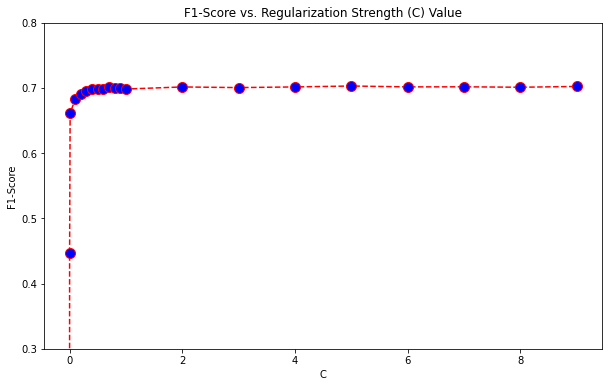


Overall Maximum F1-Score: 0.703 at regularization strength (C)  = 5.0


In [22]:
train_data_normalized_LR = pd.DataFrame(scale(train_data_LR))
dev_data_normalized_LR = pd.DataFrame(scale(dev_data_LR))

# initialize some empty lists to store results
f1_score_LR = []
weights_LR = []

#create a custom list that covers different orders of magnitude for the different regularization strengths
c_range_i = np.concatenate(([0.0001, 0.001, 0.01], 
                            np.arange(0.1, 1, 0.1), 
                            np.arange(1, 10, 1))) 

print("Regularization Stengths:")
for i in c_range_i:
    print(round(i,3), end=", ")

    # Create a Logistic regression model with an L1 penalty 
    LogisRegL1 = LogisticRegression(C=i, penalty = "l1", tol=0.015, solver="liblinear")
    LogisRegL1.fit(train_data_normalized_LR, train_labels.values.ravel())
    weight_sum = np.sum(LogisRegL1.coef_, axis = 0)
    idx = np.where(weight_sum != 0)[0]
    # then filter the data forfeatures where the weights are nonzero to train another logistic regression model with an L2 penalty
    train_data2 = train_data_normalized_LR.iloc[:, idx]
    dev_data2 = dev_data_normalized_LR.iloc[:, idx]
    
    #Some values of C don't converge. Use a try block to calculate the L2. Otherwise output L1
    try:
        LogisRegL2 = LogisticRegression(C=i, penalty = "l2")
        LogisRegL2.fit(train_data2, train_labels.values.ravel())   
        dev_data_pred_LR = LogisRegL2.predict(dev_data2)
        f1_score_LR.append(metrics.f1_score(dev_labels, dev_data_pred_LR, average="weighted"))
    except:
        print("only L1 converged for c =", i)
        dev_data_pred_LR = LogisRegL1.predict(dev_data_normalized_LR)
        f1_score_LR.append(metrics.f1_score(dev_labels, dev_data_pred_LR, average="weighted"))
        
# Plot results for F1 vs C value    
plt.figure(figsize=(10,6))
plt.plot(c_range_i, f1_score_LR, color='red', linestyle='dashed', 
         marker='o',markerfacecolor='blue', markersize=10)
plt.title('F1-Score vs. Regularization Strength (C) Value')
plt.xlabel('C')
plt.ylabel('F1-Score')
plt.ylim([0.3, 0.8])

plt.show()

overall_f1_score = round(max(f1_score_LR),3)
print("\nOverall Maximum F1-Score:", overall_f1_score,
      "at regularization strength (C)  =",c_range_i[f1_score_LR.index(max(f1_score_LR))])
opt_cvalue_for_confusion_matrix = c_range_i[f1_score_LR.index(max(f1_score_LR))]

#### PCA

In [28]:
warnings.filterwarnings('ignore')

#Split the data into continous/discrete for PCA analysis
train_data_LR_PCA = train_data_normalized_LR
dev_data_LR_PCA = dev_data_normalized_LR

train_data_continuous = train_data_LR_PCA.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Wilderness_Area)')

train_data_discrete = train_data_LR_PCA.filter(
        regex=r'^(Soil_Type)').filter(
        regex=r'^(Cover_Type)').filter(
        regex=r'^(Wilderness_Area)')

dev_data_continuous = dev_data_LR_PCA.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Wilderness_Area)')

dev_data_discrete = dev_data_LR_PCA.filter(
        regex=r'^(Soil_Type)').filter(
        regex=r'^(Cover_Type)').filter(
        regex=r'^(Wilderness_Area)')

#Loop over different n values for the PCA and find the optimal paramters for Logistic Regression
for n in range(1,11):
    pca = PCA(n_components=n).fit(train_data_continuous)
    principal_components_train = np.column_stack((pca.transform(train_data_continuous),train_data_discrete))
    principal_components_dev = np.column_stack((pca.transform(dev_data_continuous), dev_data_discrete))
    principal_components_train = pd.DataFrame(principal_components_train).clip(lower=0)
    principal_components_dev = pd.DataFrame(principal_components_dev).clip(lower=0)
    
    #initialize empty list to store model results
    f1_score_LR = []
    param_list = []
    #search for optimal point around the base model grid search max combination
    step = 50
    c_range_i = np.arange(0.1, 300, step)

    for i in c_range_i:
        ##     Best Performance - 0.68 F1
        LogisRegL1 = LogisticRegression(C=i, solver="liblinear", multi_class="auto", penalty = "l1", tol=0.015)
        LogisRegL1.fit(principal_components_train, train_labels.values.ravel())
        weight_sum = np.sum(LogisRegL1.coef_, axis = 0)
        idx = np.where(weight_sum != 0)[0]
        train_data2 = principal_components_train.iloc[:, idx]
        dev_data2 = principal_components_dev.iloc[:, idx]

        LogisRegL2 = LogisticRegression(C=i, solver="liblinear", multi_class="auto", penalty = "l2")
        LogisRegL2.fit(train_data2, train_labels.values.ravel())   
        dev_data_pred_LR = LogisRegL2.predict(dev_data2)
        f1_score_LR.append(metrics.f1_score(dev_labels, dev_data_pred_LR, average="weighted"))
        
        param_list.append(i)

    overall_f1_score = round(max(f1_score_LR),2)
    overall_f1_score_loc = f1_score_LR.index(max(f1_score_LR))

    print("\nOverall Maximum F1-Score at pca_n =", n, ": F1 score =", overall_f1_score,
      "at C =",param_list[overall_f1_score_loc])  


Overall Maximum F1-Score at pca_n = 1 : 0.22 at C = 50.1

Overall Maximum F1-Score at pca_n = 2 : 0.27 at C = 50.1

Overall Maximum F1-Score at pca_n = 3 : 0.34 at C = 0.1

Overall Maximum F1-Score at pca_n = 4 : 0.4 at C = 50.1

Overall Maximum F1-Score at pca_n = 5 : 0.4 at C = 200.1

Overall Maximum F1-Score at pca_n = 6 : 0.47 at C = 0.1

Overall Maximum F1-Score at pca_n = 7 : 0.5 at C = 50.1

Overall Maximum F1-Score at pca_n = 8 : 0.53 at C = 50.1

Overall Maximum F1-Score at pca_n = 9 : 0.48 at C = 100.1

Overall Maximum F1-Score at pca_n = 10 : 0.51 at C = 100.1


PCA did not improve the performance of the logistic regression model. 

#### Confusion Matrix


Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.66
2	Lodgepole Pine  	 0.54
3	Ponderosa Pine  	 0.57
4	Cottonwood/Willow	 0.82
5	Aspen           	 0.71
6	Douglas-fir     	 0.56
7	Krummholz       	 0.87


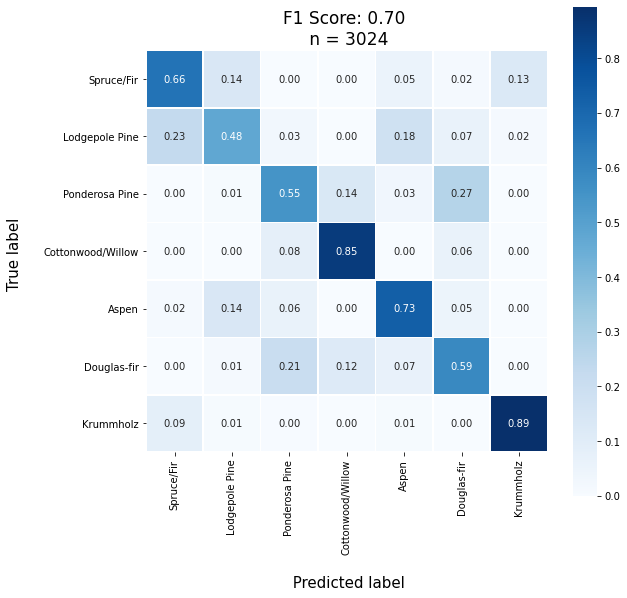

In [58]:
LogisRegL1 = LogisticRegression(C=c_range_i[f1_score_LR.index(max(f1_score_LR))],
                                solver="liblinear", multi_class="auto", 
                                penalty = "l1", tol=0.015)

LogisRegL1.fit(train_data_normalized, train_labels.values.ravel())
weight_sum = np.sum(LogisRegL1.coef_, axis = 0)
idx = np.where(weight_sum != 0)[0]
train_data2 = pd.DataFrame(train_data_normalized).iloc[:, idx]
dev_data2 = pd.DataFrame(dev_data_normalized).iloc[:, idx]

LogisRegL2 = LogisticRegression(C=opt_cvalue_for_confusion_matrix,
                                solver="liblinear", multi_class="auto", penalty = "l2")
LogisRegL2.fit(train_data2, train_labels.values.ravel())   
dev_data_pred_LR = LogisRegL2.predict(dev_data2)
    
class_f1_scores =  metrics.f1_score(dev_labels, dev_data_pred_LR, average=None)

print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')

    
#Confusion Matrix
cm = metrics.confusion_matrix(dev_labels, dev_data_pred_LR)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels, )
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(overall_f1_score, dev_data_pred_LR.size)
plt.title(all_sample_title, size = 17);

The base Logistic Regression model resulted in an F1 score of 0.48. By optimizing the hyperparameters and scaling the data, we were able to increase the model performance to 0.70.

### Decision Trees  <a class="anchor" id="dt"></a>

Decision Trees are an non-paramteric model that take observations, which can be nonlinear, about an input and make predictions about the inputs's target value. Each decision made by the althorithm pushes the final classification further down the tree towards the nodes until a final class is chosen. Decision trees are built by recursively splitting the training observations using the features from the data best suited for the specific classifcation task (i.e. determing cover type).

#### Base Model

In [30]:
# Basic Decision Tree
tree_basic_clf = DecisionTreeClassifier(random_state=0).fit(train_data, train_labels)
tree_basic_pred = tree_basic_clf.predict(dev_data)

tree_basic_score = metrics.f1_score(dev_labels, tree_basic_pred, average='weighted')
print("Basic decision tree F1 score: ", tree_basic_score)

Basic decision tree F1 score:  0.7720792626183651


The basic decision tree model with no tuning performs quite well relative to the other simple models we have tried so far. 

#### Scale the Data

Scaling is not necessary for a decision tree classifier, as it does not use gradient descent or other algorithms where the relative size of the features could influence the model. We test it out below just to make sure that the empirical results fit with our understanding. 

In [31]:
train_data_normalized = scale(train_data)
dev_data_normalized = scale(dev_data)

tree_scaled_clf = DecisionTreeClassifier(random_state=0).fit(train_data_normalized, train_labels)
tree_scaled_pred = tree_scaled_clf.predict(dev_data_normalized)

tree_scaled_score = metrics.f1_score(dev_labels, tree_scaled_pred, average='weighted')
print("Scaled decision tree F1 score: ", tree_scaled_score)

Scaled decision tree F1 score:  0.7656925024303473


Scaling the data very slightly reduces the F1-score of the model. We will proceed without scaling.

#### Optimize Hyperparameters

In [32]:
# Set values of hyperparameters to check
params = {'max_depth': [18, 19, 20, 21],
         'max_leaf_nodes': [810, 815, 820, 825, 830, 835, 840],
         'max_features': [52, 53, 54],
         'min_impurity_decrease':[0.0, 0.000001, 0.00001, 0.0001, 0.001] }

# Initiate gridsearch and fit model
tree_cv_clf = GridSearchCV(tree_basic_clf, params, cv=None, scoring='accuracy')
tree_cv_clf.fit(train_data, train_labels)

# Show top 10 parameter combinations by mean test score
pd.DataFrame(tree_cv_clf.cv_results_).loc[:, ["params", "mean_test_score"]].sort_values("mean_test_score", ascending = False)[0:10]

params  \
90     {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 830, 'min_impurity_decrease': 0.0}   
93  {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 830, 'min_impurity_decrease': 0.0001}   
92   {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 830, 'min_impurity_decrease': 1e-05}   
91   {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 830, 'min_impurity_decrease': 1e-06}   
75     {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 815, 'min_impurity_decrease': 0.0}   
76   {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 815, 'min_impurity_decrease': 1e-06}   
77   {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 815, 'min_impurity_decrease': 1e-05}   
78  {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 815, 'min_impurity_decrease': 0.0001}   
81   {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 820, 'min_impurity_decrease': 1e-06}   
83  {'max_depth': 18, 'max_features': 54, 'max_leaf_nodes': 820, 'min_impurity_decrease': 0.0001}   

    mean_test_score  
90         0.773150  
93         0.773150  
92         0.773150  
91         0.773150  
75         0.772930  
76         0.772930  
77         0.772930  
78         0.772930  
81         0.772819  
83         0.772819

In [23]:
# Tuned Decision Tree
tree_tuned_clf = DecisionTreeClassifier(random_state=0,
                                        max_depth = 18, 
                                        max_features = 54, 
                                        max_leaf_nodes = 830,
                                        min_impurity_decrease = 0
                                       ).fit(train_data, train_labels)
tree_tuned_pred = tree_tuned_clf.predict(dev_data)

tree_tuned_score = metrics.f1_score(dev_labels, tree_tuned_pred, average='weighted')
print("Tuned decision tree F1 score: ", tree_tuned_score)

Tuned decision tree F1 score:  0.7767490947501334


Tuning hyperparameters resulted in a very slight improvement in the F1 score.

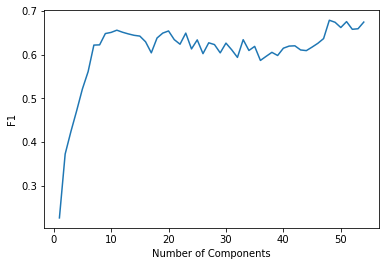

Max F1 score: 0.6786106563084999 with n = 48


In [126]:
# Try various PCA component values to find best
def test_pca(k): 
    train_data_continuous = train_data_LR_PCA.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Wilderness_Area)')

    train_data_discrete = train_data_LR_PCA.filter(
            regex=r'^(Soil_Type)').filter(
            regex=r'^(Cover_Type)').filter(
            regex=r'^(Wilderness_Area)')

    dev_data_continuous = dev_data_LR_PCA.filter(
            regex=r'^(?!Soil_Type)').filter(
            regex=r'^(?!Cover_Type)').filter(
            regex=r'^(?!Wilderness_Area)')

    dev_data_discrete = dev_data_LR_PCA.filter(
            regex=r'^(Soil_Type)').filter(
            regex=r'^(Cover_Type)').filter(
            regex=r'^(Wilderness_Area)')
    
    
    pca_model = PCA(n_components = k, random_state = 0)
    pca_model.fit(train_data_continuous)
#     pca_model.fit(train_data)
    
#     Xtrain_pca = pca_model.transform(train_data)
#     Xdev_pca = pca_model.transform(dev_data)

    Xtrain_pca = np.column_stack((pca_model.transform(train_data_continuous),train_data_discrete))
    Xdev_pca = np.column_stack((pca_model.transform(dev_data_continuous), dev_data_discrete))
    Xtrain_pca = pd.DataFrame(Xtrain_pca).clip(lower=0)
    Xdev_pca = pd.DataFrame(Xdev_pca).clip(lower=0)

    tree_pca_clf = DecisionTreeClassifier(random_state=0, 
                                        max_depth = tree_cv_clf.best_params_["max_depth"], 
                                        #max_features = tree_cv_clf.best_params_["max_features"], 
                                        max_leaf_nodes = tree_cv_clf.best_params_["max_leaf_nodes"],
                                        min_impurity_decrease = tree_cv_clf.best_params_["min_impurity_decrease"]
                                       ).fit(Xtrain_pca, train_labels)
    tree_pca_pred = tree_pca_clf.predict(Xdev_pca)

    overall_f1_score = metrics.f1_score(dev_labels, tree_pca_pred, average='weighted')
    f1_array.append(overall_f1_score)

    
n_components_array = np.arange(1, 55, 1)
f1_array = []
for k in n_components_array:
    test_pca(k)
    
plt.plot(n_components_array, f1_array)
plt.xlabel("Number of Components")
plt.ylabel("F1")
plt.show()

# Find max value
print("Max F1 score:", max(f1_array), "with n =", n_components_array[np.argmax(f1_array)])

Preprocessing with PCA slightly reduces the F1-score. We will proceed without using PCA to preprocess.

#### Confusion Matrix for Best Model

Overall F1 score:  0.7767490947501334

Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.68
2	Lodgepole Pine  	 0.64
3	Ponderosa Pine  	 0.69
4	Cottonwood/Willow	 0.91
5	Aspen           	 0.87
6	Douglas-fir     	 0.74
7	Krummholz       	 0.91


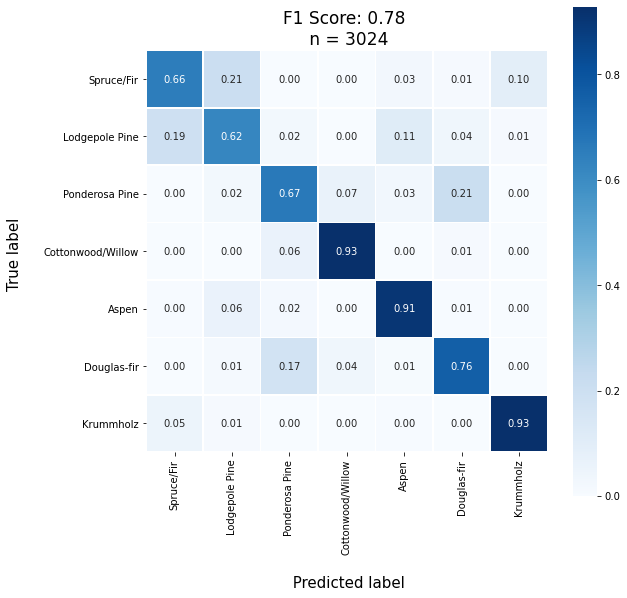

In [24]:
tree_best_clf = DecisionTreeClassifier(random_state=0, 
                                        max_depth = 18, 
                                        max_features = 54, 
                                        max_leaf_nodes = 830,
                                        min_impurity_decrease = 0
                                       ).fit(train_data, train_labels)
tree_best_pred = tree_best_clf.predict(dev_data)

tree_best_score = metrics.f1_score(dev_labels, tree_best_pred, average='weighted')
class_f1_scores =  metrics.f1_score(dev_labels, tree_best_pred, average=None)

print("Overall F1 score: ", tree_best_score)
print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')

cm = metrics.confusion_matrix(dev_labels, tree_best_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels, )
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(tree_best_score, tree_best_pred.size)
plt.title(all_sample_title, size = 17);

### Support Vector Machines  <a class="anchor" id="svm"></a>

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space that distinctly classifies the data points. To separate two classes of points, there are many possible hyperplanes that may separate the data. However, SVMs find the plane with the maximum margin, i.e the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence.

#### Base Model

In [25]:
#radial kernel
rbf_clf = SVC(kernel='rbf') 
rbf_clf.fit(train_data, train_labels.values.ravel())

pred = rbf_clf.predict(dev_data)

print("Base SVM Model - F1 score: ", round(metrics.f1_score(dev_labels, pred, average='weighted'),2))
class_f1_scores =  metrics.f1_score(dev_labels, pred, average=None)

Base SVM Model - F1 score:  0.63


#### Scale the Data

Scaling the data significantly improved performance of the SVM algorithm

In [27]:
train_data_SVM = train_data
dev_data_SVM = dev_data

train_data_normalized_SVM = scale(train_data_SVM)
dev_data_normalized_SVM = scale(dev_data_SVM)

SVM = SVC(kernel='rbf') 
SVM.fit(train_data_normalized_SVM, train_labels.values.ravel())
dev_data_pred_SVM = SVM.predict(dev_data_normalized_SVM)
f1_score_SVM = metrics.f1_score(dev_labels, dev_data_pred_SVM, average="weighted")

print("\nScaled Base Model - F1-Score:", round(f1_score_SVM,2))


Scaled Base Model - F1-Score: 0.73


#### Optimize Hyperparameters

In [39]:
warnings.filterwarnings('ignore')

#set values of hyperparameters
params = {'C': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100, 1000],
         'gamma': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100, 1000]}

#initiate gridsearch and fit model
clf = GridSearchCV(SVM, params, cv=None, scoring='accuracy')
clf.fit(train_data_normalized_SVM, train_labels.values.ravel())

#show results of gridsearch
print("The best value of C is", clf.best_params_["C"])
print("The best value of gamma is", clf.best_params_["gamma"])


The best value of C is 10.0
The best value of gamma is 0.1


#### Confusion Matrix for Best Model

Optimizing the hyperparamers also significantly increases the model performance

Overall F1 score:  0.8133830337646496

Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.72
2	Lodgepole Pine  	 0.67
3	Ponderosa Pine  	 0.78
4	Cottonwood/Willow	 0.93
5	Aspen           	 0.88
6	Douglas-fir     	 0.79
7	Krummholz       	 0.93


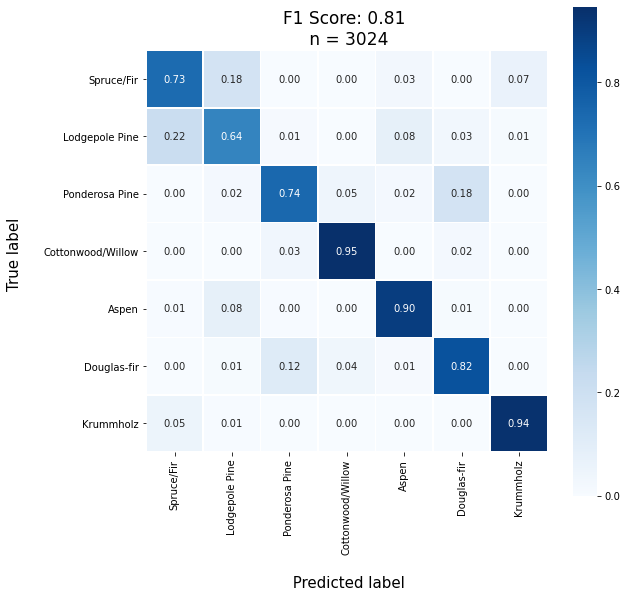

In [28]:
#radial kernel with adjusted C and gamma
svm_best_clf = SVC(kernel='rbf', C=100, gamma=0.1, probability=True) 
svm_best_clf.fit(train_data_normalized_SVM, train_labels.values.ravel())


pred = svm_best_clf.predict(dev_data_normalized_SVM)

print("Overall F1 score: ", metrics.f1_score(dev_labels, pred, average='weighted'))
class_f1_scores =  metrics.f1_score(dev_labels, pred, average=None)

print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')

#to plot confusion matrix
score = metrics.f1_score(dev_labels, pred, average='weighted')
cm = metrics.confusion_matrix(dev_labels, pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels)
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(score, pred.size)
plt.title(all_sample_title, size = 17);

### Random Forest  <a class="anchor" id="rf"></a>

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

#### Base Model

In [29]:
rf_basic_clf = RandomForestClassifier(random_state = 0).fit(train_data, train_labels.values.flatten())
rf_basic_pred = rf_basic_clf.predict(dev_data)

rf_basic_score = metrics.f1_score(dev_labels, rf_basic_pred, average='weighted')
print("F1 Score for basic random forest model: ", rf_basic_score)

F1 Score for basic random forest model:  0.8381070461193986


The default settings for the random forest classifier perform quite well, with an F1 score of 0.84. The default number of estimators is 100.

#### Scale the Data

In [30]:
# Use scaled data and fit the Random Forest Classifier
rf_scaled_clf = RandomForestClassifier(random_state = 0).fit(train_data_normalized, train_labels.values.flatten())
rf_scaled_pred = rf_scaled_clf.predict(dev_data_normalized)

rf_scaled_score = metrics.f1_score(dev_labels, rf_scaled_pred, average='weighted')
print("F1 Score for scaled random forest model: ", rf_scaled_score)

F1 Score for scaled random forest model:  0.841484680693008


Scaling the data slightly improved the performance of the random forest model. 

#### Optimize Hyperparameters

In [43]:
# First try passing in the parameters of the best-performing decision tree model found earlier
rf_cv0_clf = RandomForestClassifier(random_state = 0,
                                    max_depth = tree_cv_clf.best_params_["max_depth"], 
                                    max_features = tree_cv_clf.best_params_["max_features"], 
                                    max_leaf_nodes = tree_cv_clf.best_params_["max_leaf_nodes"],
                                    min_impurity_decrease = tree_cv_clf.best_params_["min_impurity_decrease"]
                                    ).fit(train_data, train_labels.values.flatten())
  
rf_cv0_pred = rf_cv0_clf.predict(dev_data)

rf_cv0_score = metrics.f1_score(dev_labels, rf_cv0_pred, average='weighted')
print("F1 Score for (decision-tree tuned) random forest model: ", rf_cv0_score)

F1 Score for (decision-tree tuned) random forest model:  0.8405343700518704


In [44]:
# Use gridsearch to optimize hyperparameters specific to random forest classifier

#set values of hyperparameters
params = {'n_estimators': [175, 200, 225],
         'bootstrap': [True, False],
         'warm_start': [True, False],
         'max_samples': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]}

#initiate gridsearch and fit model
clf = GridSearchCV(rf_basic_clf, params, cv=None, scoring='accuracy')
clf.fit(train_data, train_labels.values.flatten())

pd.DataFrame(clf.cv_results_).loc[:, ["params", "mean_test_score"]].sort_values("mean_test_score", ascending = False)[1:10]

params  \
72   {'bootstrap': False, 'max_samples': 0.95, 'n_estimators': 175, 'warm_start': True}   
60   {'bootstrap': False, 'max_samples': 0.85, 'n_estimators': 175, 'warm_start': True}   
61  {'bootstrap': False, 'max_samples': 0.85, 'n_estimators': 175, 'warm_start': False}   
54    {'bootstrap': False, 'max_samples': 0.8, 'n_estimators': 175, 'warm_start': True}   
43   {'bootstrap': False, 'max_samples': 0.7, 'n_estimators': 175, 'warm_start': False}   
66    {'bootstrap': False, 'max_samples': 0.9, 'n_estimators': 175, 'warm_start': True}   
67   {'bootstrap': False, 'max_samples': 0.9, 'n_estimators': 175, 'warm_start': False}   
55   {'bootstrap': False, 'max_samples': 0.8, 'n_estimators': 175, 'warm_start': False}   
73  {'bootstrap': False, 'max_samples': 0.95, 'n_estimators': 175, 'warm_start': False}   

    mean_test_score  
72         0.846783  
60         0.846783  
61         0.846783  
54         0.846783  
43         0.846783  
66         0.846783  
67         0.846783  
55         0.846783  
73         0.846783

Optimizing the parameters related specifically to the random forest classifier provided better F1 scores than using the parameters from the optimized decision tree that were found earlier. After trying various combinations of optimized parameters and scaling, it appears that the default settings for the decision tree with the optimized settings for the random forest parameters yields the best results. Also, while using scaled data slightly improved the random forest model with default settings, the optimized random forest model actually does slightly worse with scaled data (since these are random forests, we don't expect to have to scale the data for the models to work properly, so we will proceed without scaling). 

#### PCA

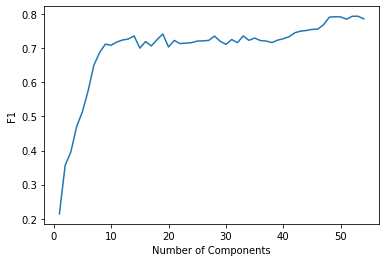

In [124]:
# Random Forest with optimized parameters and PCA-transformed input data
def test_pca(k): 
    train_data_continuous = train_data_LR_PCA.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Wilderness_Area)')

    train_data_discrete = train_data_LR_PCA.filter(
            regex=r'^(Soil_Type)').filter(
            regex=r'^(Cover_Type)').filter(
            regex=r'^(Wilderness_Area)')

    dev_data_continuous = dev_data_LR_PCA.filter(
            regex=r'^(?!Soil_Type)').filter(
            regex=r'^(?!Cover_Type)').filter(
            regex=r'^(?!Wilderness_Area)')

    dev_data_discrete = dev_data_LR_PCA.filter(
            regex=r'^(Soil_Type)').filter(
            regex=r'^(Cover_Type)').filter(
            regex=r'^(Wilderness_Area)')
    
    
    pca_model = PCA(n_components = k, random_state = 0)
    pca_model.fit(train_data_continuous)
#     pca_model.fit(train_data)
    
#     Xtrain_pca = pca_model.transform(train_data)
#     Xdev_pca = pca_model.transform(dev_data)

    Xtrain_pca = np.column_stack((pca_model.transform(train_data_continuous),train_data_discrete))
    Xdev_pca = np.column_stack((pca_model.transform(dev_data_continuous), dev_data_discrete))
    Xtrain_pca = pd.DataFrame(Xtrain_pca).clip(lower=0)
    Xdev_pca = pd.DataFrame(Xdev_pca).clip(lower=0)
 
    
    
    clf_rf4 = RandomForestClassifier(random_state = 0,
                                 n_estimators = 175,
                                 bootstrap = False,
                                 max_samples = 0.95,
                                 warm_start = True
                                 )  
    clf_rf4.fit(Xtrain_pca, train_labels.values.flatten())
  
    rf_pred4 = clf_rf4.predict(Xdev_pca)

    overall_f1_score = metrics.f1_score(dev_labels, rf_pred4, average='weighted')
    f1_array.append(overall_f1_score)

n_components_array = np.arange(1, 55, 1)
f1_array = []
for k in n_components_array:
    test_pca(k)
    
plt.plot(n_components_array, f1_array)
plt.xlabel("Number of Components")
plt.ylabel("F1")
plt.show()

In [125]:
# Find max value
print("Max F1 score:", max(f1_array), "with n =", n_components_array[np.argmax(f1_array)])

Max F1 score: 0.7939446158060729 with n = 53


PCA slightly reduces the F1 score for the random forest model, so we will proceed without it. 

#### Confusion Matrix for Best Model

Overall F1 score:  0.8729704786743749

Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.81
2	Lodgepole Pine  	 0.75
3	Ponderosa Pine  	 0.86
4	Cottonwood/Willow	 0.94
5	Aspen           	 0.92
6	Douglas-fir     	 0.88
7	Krummholz       	 0.96


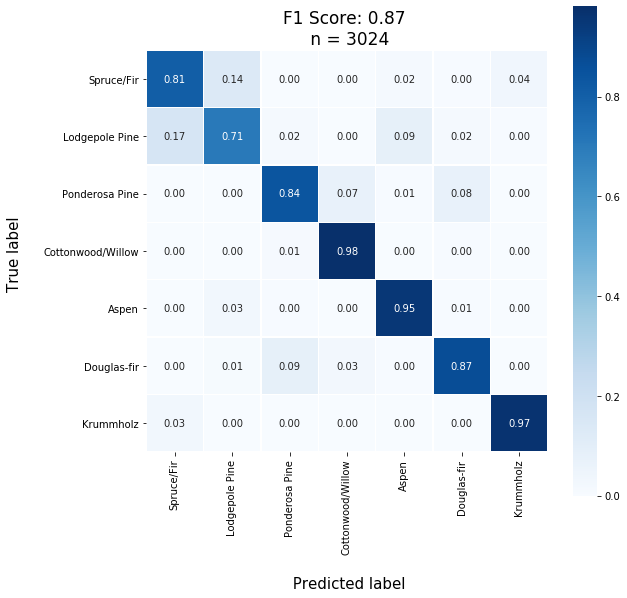

In [112]:
# Use the optimized random forest hyperparameters (but leave the decision tree parameters at their defaults and don't use scaling)
rf_best_clf = RandomForestClassifier(random_state = 0,
                                     n_estimators = 175,
                                     bootstrap = False,
                                     max_samples = 0.95,
                                     warm_start = True
                                     ).fit(train_data, train_labels.values.flatten())
  
rf_best_pred = rf_best_clf.predict(dev_data)

rf_best_score = metrics.f1_score(dev_labels, rf_best_pred, average='weighted')
class_f1_scores =  metrics.f1_score(dev_labels, rf_best_pred, average=None)

print("Overall F1 score: ", rf_best_score)
print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')
    
cm = metrics.confusion_matrix(dev_labels, rf_best_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels, )
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(rf_best_score, rf_best_pred.size)
plt.title(all_sample_title, size = 17);    

The best F1-score is 0.87. The model does better without scaling and without decision-tree-specific tuned parameters, although optimizing the random-forest-specific parameters did improve performance.

### AdaBoost  <a class="anchor" id="ab"></a>

AdaBoost is a boosting algorithm that combines multiple “weak classifiers” into a single “strong classifier”. The weak learners in AdaBoost are decision trees with a single split, called decision stumps. AdaBoost works by putting more weight on difficult-to-classify instances and less on those already handled well. In this way, it can "boost" the difficult data points until it gets them correct, ultimately improving the overall accuracy.

#### Base Model

In [47]:
#AdaBoost Classifier
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20))
ada.fit(train_data, train_labels)
pred = ada.predict(dev_data)

print("Base AdaBoost Model - F1 score: ", round(metrics.f1_score(dev_labels, pred, average='weighted'),2))
class_f1_scores =  metrics.f1_score(dev_labels, pred, average=None)

Base AdaBoost Model - F1 score:  0.85


#### Scale the Data

Scaling the data did not improve performance of the AdaBoost Classifier, so we exclude it here

#### Optimize Hyperparameters

In [48]:
warnings.filterwarnings('ignore')

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20))
ada.fit(train_data, train_labels)

#set values of hyperparameters
params = {'n_estimators': [1, 10, 100, 500],
         'learning_rate': [0.5, 1, 5, 10]}

#initiate gridsearch and fit model
clf = GridSearchCV(ada, params, cv=None, scoring='accuracy')
clf.fit(train_data, train_labels)

#show results of gridsearch
print("The best value of n_estimators is", clf.best_params_["n_estimators"])
print("The best value of learning_rate is", clf.best_params_["learning_rate"])

The best value of n_estimators is 500
The best value of learning_rate is 1


#### Confusion Matrix for Best Model

Optimizing the hyperparameters improves the model performance slightly. 

Overall F1 score:  0.858253324395563

Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.78
2	Lodgepole Pine  	 0.74
3	Ponderosa Pine  	 0.84
4	Cottonwood/Willow	 0.94
5	Aspen           	 0.92
6	Douglas-fir     	 0.85
7	Krummholz       	 0.95


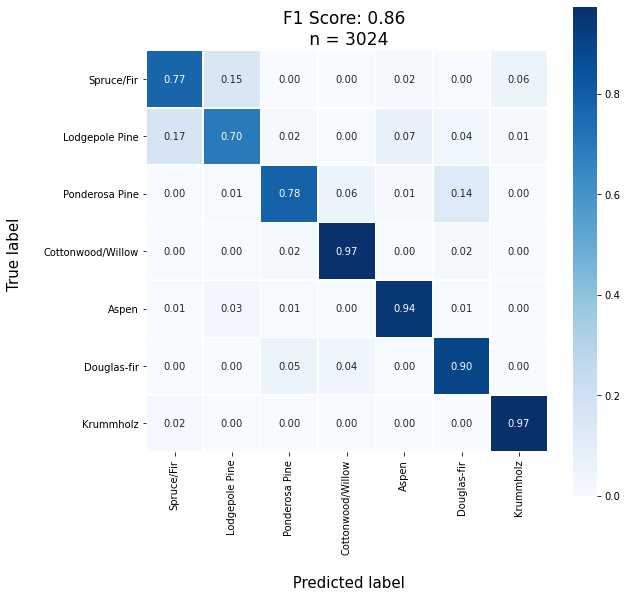

In [27]:
#AdaBoost Classifier
ada_best_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=500, learning_rate=1)
ada_best_clf.fit(train_data, train_labels.values.ravel())
pred = ada_best_clf.predict(dev_data)

print("Overall F1 score: ", metrics.f1_score(dev_labels, pred, average='weighted'))
class_f1_scores =  metrics.f1_score(dev_labels, pred, average=None)

print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')

#to plot confusion matrix
score = metrics.f1_score(dev_labels, pred, average='weighted')
cm = metrics.confusion_matrix(dev_labels, pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels)
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(score, pred.size)
plt.title(all_sample_title, size = 17);

## Feature Engineering  <a class="anchor" id="feat"></a>

In attempt to increase our accuracy, we tested various methods of feature engineering. This included dimentionality reduction using PCA, combining the discrete soil type features into families, and adding new features using the existing features. Here, we summarize a few of these attempts

#### General PCA Investigation

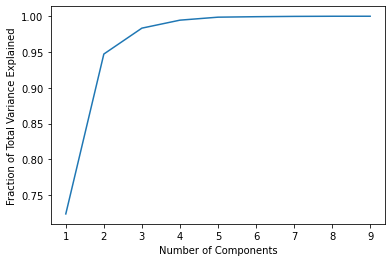

In [57]:
# Check what percentage of the variance is explained with increasing numbers of components via PCA
def run_pca(n_components):
    
    pca_model = PCA(n_components, random_state = 0)
    pca_model.fit(train_data)
    X_pca = pca_model.transform(train_data)
    var_explain_array.append(sum(pca_model.explained_variance_ratio_))

n_components_array = np.arange(1, 10, 1)
var_explain_array = []
for k in n_components_array:
    run_pca(k)
    
plt.plot(n_components_array, var_explain_array)
plt.xlabel("Number of Components")
plt.ylabel("Fraction of Total Variance Explained")
plt.show()  

It appears that the fraction of total variance explained fairly quickly approaches its maximum value; even including just the top 5 principal components should give good capture of information. However, in practice, we found that many of our models did slightly better without PCA. If we were trying to create very efficient models rather than maximizing the F1 score, we could utilize a smaller number of components without losing too much in the way of accuracy. 

#### Soil Type

We noticed that there were patterns in the names of the soil types that indicated higher-level associations across different soil types, so we decided to add binary flags for the presence of these higher-level categories. Each soil type (and therefore each forest patch) can have as many of these new soil groupings as appear in the original soil type name. Below we read in, transform, and combine these groupings with the provided data and then test our best model on it.

In [67]:
# Read in addtl soil type classification and transform to merge with existing data
soil_df = pd.read_csv('./data/soil_classification.csv').set_index('Soil_Type')
class1 = pd.get_dummies(soil_df[['Class 1']], prefix = "Soil")
class2 = pd.get_dummies(soil_df[['Class 2']], prefix = "Soil")
class3 = pd.get_dummies(soil_df[['Class 3']], prefix = "Soil")

soil_df2 = pd.concat([class1.transpose(), class2.transpose(), class3.transpose()], axis = 0)
soil_df2.reset_index(inplace = True)
soil_df2 = soil_df2.rename(columns = {'index':'Soil_Type'})
soil_df3 = soil_df2.groupby('Soil_Type').sum().transpose()

train_data2 = train_data.copy(deep = True)
train_data2['Soil_Type'] = train_data2.filter(regex=r'Soil_Type*').idxmax(axis=1)
train_data3 = pd.merge(train_data2, soil_df3, how = 'left', on = 'Soil_Type').drop(columns ='Soil_Type')

dev_data2 = dev_data.copy(deep=True)
dev_data2['Soil_Type'] = dev_data2.filter(regex=r'Soil_Type*').idxmax(axis=1)
dev_data3 = pd.merge(dev_data2, soil_df3, how = 'left', on = 'Soil_Type').drop(columns ='Soil_Type')

In [69]:
rf_soil_clf = RandomForestClassifier(random_state = 0,
                                     n_estimators = 175,
                                     bootstrap = False,
                                     max_samples = 0.95,
                                     warm_start = True
                                     ).fit(train_data3, train_labels.values.flatten())
  
rf_soil_pred = rf_soil_clf.predict(dev_data3)

rf_soil_score = metrics.f1_score(dev_labels, rf_soil_pred, average='weighted')

print("Overall F1 score: ", rf_soil_score)

Overall F1 score:  0.8471073991482637


Adding more information about soil type groupings did not improve the F1 score from our best model, the tuned Random Forest.

## Ensemble Models  <a class="anchor" id="ensemble"></a>

As our final model to use in the Kaggle competiton, we decided to ensemble the best models together and use this ensemble model to predict final cover types from the test data. Each of our models above performed slightly differently and had different strengths and weaknesses. Because of this, we thought that using a vote or stack of each model's prediction should yield the best accuracy. Here, we ensemble our top 5 highest performing models and use them to take a final vote or stack of the predicted cover type.

In [92]:
# List estimators to include
# Includes decision trees, SVM, random forest, adaboost, and KNN
estimators = [
    ('dt', tree_best_clf),
    ('sv', svm_best_clf),
    ('rf', rf_best_clf),
    ('ab', ada_best_clf),
    ('kn', neigh_best)
]

Overall F1 score:  0.8616881880184303

Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.78
2	Lodgepole Pine  	 0.74
3	Ponderosa Pine  	 0.84
4	Cottonwood/Willow	 0.94
5	Aspen           	 0.92
6	Douglas-fir     	 0.86
7	Krummholz       	 0.95


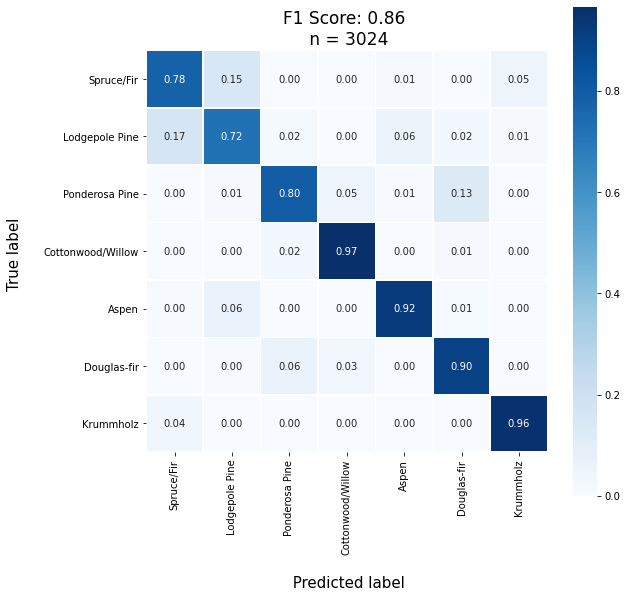

In [95]:
# Stacking classifier
#Scaled Data
final_stack = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression()
).fit(train_data_normalized, train_labels.values.flatten())

pred = final_stack.predict(dev_data_normalized)

print("Overall F1 score: ", metrics.f1_score(dev_labels, pred, average='weighted'))
class_f1_scores =  metrics.f1_score(dev_labels, pred, average=None)

print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')

#to plot confusion matrix
score = metrics.f1_score(dev_labels, pred, average='weighted')
cm = metrics.confusion_matrix(dev_labels, pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels)
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(score, pred.size)
plt.title(all_sample_title, size = 17);

Overall F1 score:  0.8586631863054154

Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.78
2	Lodgepole Pine  	 0.71
3	Ponderosa Pine  	 0.85
4	Cottonwood/Willow	 0.93
5	Aspen           	 0.91
6	Douglas-fir     	 0.87
7	Krummholz       	 0.96


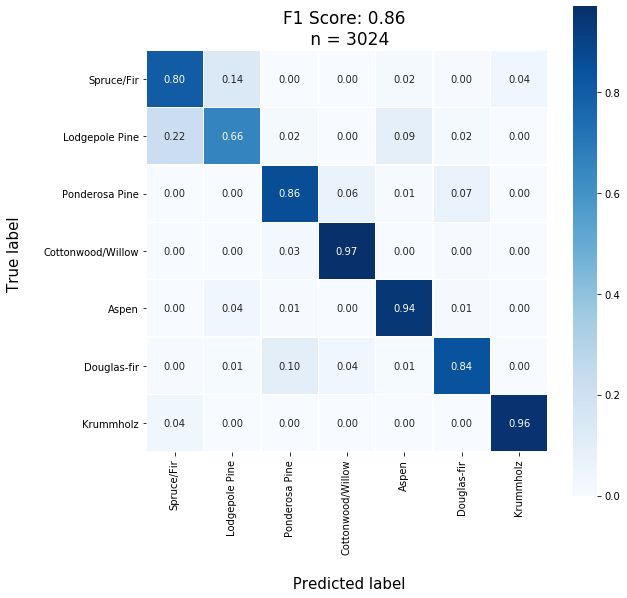

In [167]:
# Voting classifier
clf = VotingClassifier(
    estimators=estimators, 
    voting = 'hard'
)

clf.fit(train_data_normalized, train_labels.values.flatten())
pred = clf.predict(dev_data_normalized)


print("Overall F1 score: ", metrics.f1_score(dev_labels, pred, average='weighted'))
class_f1_scores =  metrics.f1_score(dev_labels, pred, average=None)

print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')

#to plot confusion matrix
score = metrics.f1_score(dev_labels, pred, average='weighted')
cm = metrics.confusion_matrix(dev_labels, pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels)
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(score, pred.size)
plt.title(all_sample_title, size = 17);

Both kinds of ensemble models (voting and stacking) performed similarly. Although the F1 score for these models is slightly lower than the F1 score for the tuned Random Forest model, we decided to use the stacked ensemble model as our final choice for running on our test data set, as we hoped it would be more robust against overfitting and therefore generalize well to the test data. 

#### Testing the highest performing ensemble model on our held out test data from the training set

We find that the ensemble model scores very comparably on our held-out test set as it did on our development set. Its weak point is in differentiating cover types 1 and 2 ("Spruce/Fir" and "Lodgepole Pine"), similarly to our individual models.

Final F1 score:  0.8632785809659259

Class 	Class Label 		 F1 Score
1	Spruce/Fir      	 0.78
2	Lodgepole Pine  	 0.75
3	Ponderosa Pine  	 0.82
4	Cottonwood/Willow	 0.97
5	Aspen           	 0.93
6	Douglas-fir     	 0.85
7	Krummholz       	 0.95


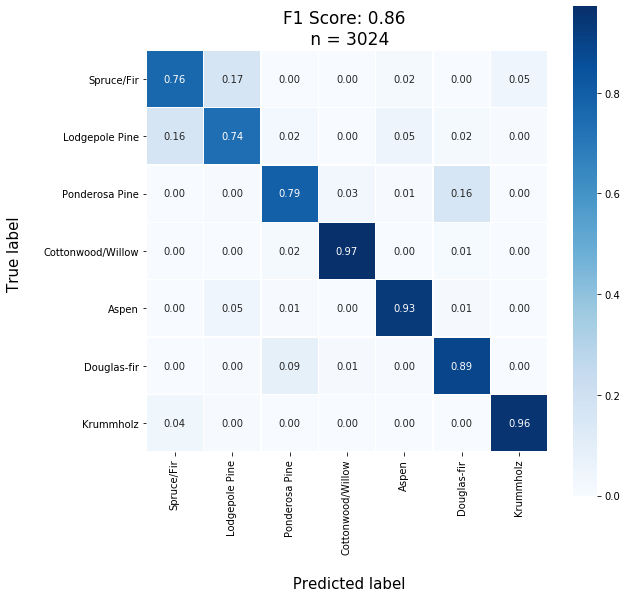

In [197]:
pred = final_stack.predict(test_data_normalized)

print("Final F1 score: ", metrics.f1_score(test_labels, pred, average='weighted'))
class_f1_scores =  metrics.f1_score(test_labels, pred, average=None)

print("\nClass \tClass Label \t\t F1 Score")
for cover, label, score in zip(cover_types, cover_labels, class_f1_scores):
    print(f'{cover:1.0f}\t{label:16s}\t{score:5.2f}')

#to plot confusion matrix
score = metrics.f1_score(test_labels, pred, average='weighted')
cm = metrics.confusion_matrix(test_labels, pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,9))
sns.heatmap(cm_percent, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Blues', xticklabels = cover_labels, yticklabels = cover_labels)
plt.ylabel('True label \n', size = 15);
plt.xlabel('\n Predicted label', size = 15);
all_sample_title = 'F1 Score: {:.2f} \n n = {}'.format(score, pred.size)
plt.title(all_sample_title, size = 17);

## Test Data  <a class="anchor" id="test"></a>

Here, we present our findings from testing our final ensemble model on the official test set provided by the Kaggle Competition

#### Import Kaggle submission test data and check quality

In [122]:
# Read in Data
kaggle_df = pd.read_csv('./data/test.csv')
print("Shape is:", kaggle_df.shape)
print("Columns are:", kaggle_df.columns)

Shape is: (565892, 55)
Columns are: Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 

All the expected columns are available in the Kaggle test dataset.

In [26]:
kaggle_df_summary = kaggle_df.describe().transpose()
pd.merge(
    train_df_summary,
    kaggle_df_summary,
    how="inner",
    left_index=True,
    right_index=True,
    suffixes=("_train", "_kaggle")
)[['count_train', 'count_kaggle', 'min_train', 'min_kaggle', 'max_train', 'max_kaggle', 
   'mean_train', 'mean_kaggle']]

count_train  count_kaggle  min_train  \
Elevation                               15120.0      565892.0     1863.0   
Aspect                                  15120.0      565892.0        0.0   
Slope                                   15120.0      565892.0        0.0   
Horizontal_Distance_To_Hydrology        15120.0      565892.0        0.0   
Vertical_Distance_To_Hydrology          15120.0      565892.0     -146.0   
Horizontal_Distance_To_Roadways         15120.0      565892.0        0.0   
Hillshade_9am                           15120.0      565892.0        0.0   
Hillshade_Noon                          15120.0      565892.0       99.0   
Hillshade_3pm                           15120.0      565892.0        0.0   
Horizontal_Distance_To_Fire_Points      15120.0      565892.0        0.0   
Wilderness_Area1                        15120.0      565892.0        0.0   
Wilderness_Area2                        15120.0      565892.0        0.0   
Wilderness_Area3                        15120.0      565892.0        0.0   
Wilderness_Area4                        15120.0      565892.0        0.0   
Soil_Type1                              15120.0      565892.0        0.0   
Soil_Type2                              15120.0      565892.0        0.0   
Soil_Type3                              15120.0      565892.0        0.0   
Soil_Type4                              15120.0      565892.0        0.0   
Soil_Type5                              15120.0      565892.0        0.0   
Soil_Type6                              15120.0      565892.0        0.0   
Soil_Type7                              15120.0      565892.0        0.0   
Soil_Type8                              15120.0      565892.0        0.0   
Soil_Type9                              15120.0      565892.0        0.0   
Soil_Type10                             15120.0      565892.0        0.0   
Soil_Type11                             15120.0      565892.0        0.0   
Soil_Type12                             15120.0      565892.0        0.0   
Soil_Type13                             15120.0      565892.0        0.0   
Soil_Type14                             15120.0      565892.0        0.0   
Soil_Type15                             15120.0      565892.0        0.0   
Soil_Type16                             15120.0      565892.0        0.0   
Soil_Type17                             15120.0      565892.0        0.0   
Soil_Type18                             15120.0      565892.0        0.0   
Soil_Type19                             15120.0      565892.0        0.0   
Soil_Type20                             15120.0      565892.0        0.0   
Soil_Type21                             15120.0      565892.0        0.0   
Soil_Type22                             15120.0      565892.0        0.0   
Soil_Type23                             15120.0      565892.0        0.0   
Soil_Type24                             15120.0      565892.0        0.0   
Soil_Type25                             15120.0      565892.0        0.0   
Soil_Type26                             15120.0      565892.0        0.0   
Soil_Type27                             15120.0      565892.0        0.0   
Soil_Type28                             15120.0      565892.0        0.0   
Soil_Type29                             15120.0      565892.0        0.0   
Soil_Type30                             15120.0      565892.0        0.0   
Soil_Type31                             15120.0      565892.0        0.0   
Soil_Type32                             15120.0      565892.0        0.0   
Soil_Type33                             15120.0      565892.0        0.0   
Soil_Type34                             15120.0      565892.0        0.0   
Soil_Type35                             15120.0      565892.0        0.0   
Soil_Type36                             15120.0      565892.0        0.0   
Soil_Type37                             15120.0      565892.0        0.0   
Soil_Type38                             15120.0      565892.0        0.0   
Soil_Typ

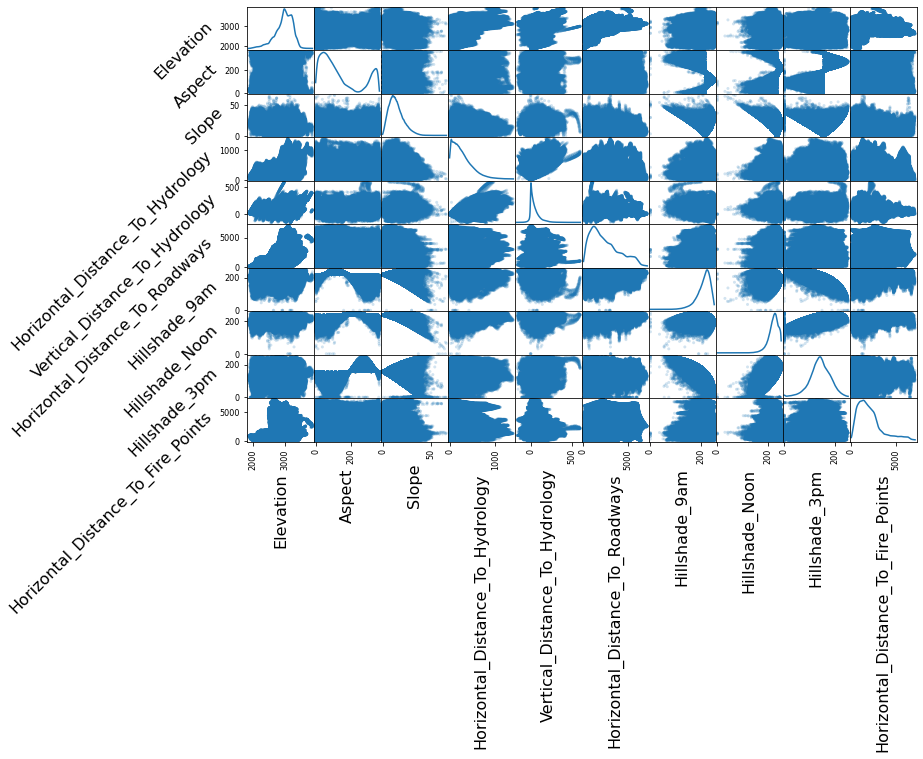

In [123]:
# Scatter plot of all variables
axes = pd.plotting.scatter_matrix(
    kaggle_df.filter(
        regex=r'^(?!Soil_Type)').filter(
        regex=r'^(?!Cover_Type)').filter(
        regex=r'^(?!Id)').filter(
        regex=r'^(?!Wilderness_Area)'),
    alpha=0.2, 
    figsize=(12, 8), diagonal='kde')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_fontsize(16)
    ax.yaxis.label.set_ha('right')

plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

While all the values in the Kaggle submission test data seem reasonable, we can see that there are some differences in the distributions between the dataset we were given to train on and this one. For example, Wilderness Area 1 makes up 24% of the train data but 45% of the Kaggle data, while Wilderness Area 4 makes up 31% of the train data and 6% of the test data. This makes it seem like our model will probably not perform as well on this dataset as it does on the portion of the full dataset we have set aside for testing.

#### Try final ensemble model on Kaggle submission data

In [202]:
# Prepare data for models
kaggle_df_normalized = kaggle_df.drop("Id", axis=1)
kaggle_df_normalized = scale(kaggle_df_normalized)

In [203]:
# Run best model on submission data
kaggle_pred = final_stack.predict(kaggle_df_normalized)

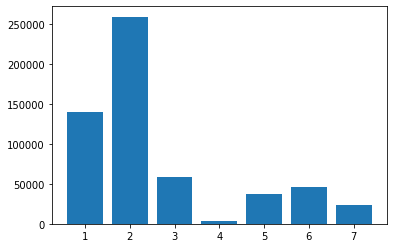

In [204]:
# Look at predicted values
unique, counts = np.unique(kaggle_pred, return_counts=True)
plt.bar(unique, counts)
plt.show()

In [206]:
# How confident is the model in the cover_type it unltimately chose?
proba = final_stack.predict_proba(kaggle_df_normalized)
np.mean(np.amax(proba, axis=1))

0.7193827177603968

In [207]:
ids = kaggle_df["Id"].values

In [208]:
#output predictions to .csv in format to submit to kaggle
np.savetxt("Final_Cover_Type_Predictions.csv", list(zip(ids,kaggle_pred)), header= "Id,Cover_Type", delimiter=",", fmt='%s')

There is a much higher proportion of forest cover types 1 and 2 predicted in the Kaggle test dataset. This is potentially concerning since we know these two cover types are the ones that our model had the hardest time classifying in our training data. Our final ensemble model is fairly confident in its predictions, but it is unlikely that the model is truly performing that well, given that we were only seeing scores in the mid 80's with our validation.

## Final Kaggle Submission Score = .61  <a class="anchor" id="conc"></a>

After submitting our final cover type prediction to Kaggle, we recieved a score of 0.61, much lower than our held out test set score of .86 implied. We presume this is becuase the Kaggle test set consisted of a different distribution of data than our test set had. The Kaggle set appears to be a high proportion of cover types 1 and 2, which were the hardest for all of our models to classify. If we had more time, we would bias our dataset to contain more of these data types and then retrain our models to perform better in this context.